# MLP

In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns

In [42]:
df_smote_1000 = pd.read_csv("../Data/df_smote_1000.csv")
df_smote_2500 = pd.read_csv("../Data/df_smote_2500.csv")
df_smote_5000 = pd.read_csv("../Data/df_smote_5000.csv")

def preprocess(df):
    # using label encoder
    le = LabelEncoder()
    df['Label_encoded'] = le.fit_transform(df['Label'])

    # separating X and y
    X = df.drop(columns=['Label', 'Label_encoded'])
    y = df['Label_encoded']

    # using standard scaler for normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
    )

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    return train_ds, test_ds, train_loader, test_loader, le
    

In [43]:
df_smote_1000_train, df_smote_1000_test, df_smote_1000_train_loader, df_smote_1000_test_loader, df_smote_1000_le = preprocess(df_smote_1000)
df_smote_2500_train, df_smote_2500_test, df_smote_2500_train_loader, df_smote_2500_test_loader, df_smote_2500_le = preprocess(df_smote_2500)
df_smote_5000_train, df_smote_5000_test, df_smote_5000_train_loader, df_smote_5000_test_loader, df_smote_5000_le = preprocess(df_smote_5000)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, output_dim)

        # Projection layer for residual connection (256 → 128)
        self.res_proj = nn.Linear(256, 128)

        self.dropout = dropout

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        residual = x  # Save for residual connection
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.res_proj(residual) + x  # Project and add residual
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.leaky_relu(self.bn4(self.fc4(x)))
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.fc5(x)

### Training and Evaluation Code

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def train_model(model, train_loader, num_epochs=200, lr=0.01, step_size=40, gamma=0.5, device='cpu'):
    '''
    num_epochs: Number of epochs to train the model
    lr: Learning rate

    #learning rate scheduler
    step_size: Number of epochs to wait before reducing the learning rate
    gamma: Factor by which the learning rate is reduced
    '''
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        loss_history.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    # plotting
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


def evaluate_model(model, test_loader, label_encoder, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Training and Evaluating SMOTE 1000 model

Epoch 10/250, Loss: 588.7357
Epoch 20/250, Loss: 570.5074
Epoch 30/250, Loss: 556.0414
Epoch 40/250, Loss: 546.7068
Epoch 50/250, Loss: 534.5371
Epoch 60/250, Loss: 533.9530
Epoch 70/250, Loss: 529.8263
Epoch 80/250, Loss: 527.6667
Epoch 90/250, Loss: 520.6271
Epoch 100/250, Loss: 517.1225
Epoch 110/250, Loss: 514.3850
Epoch 120/250, Loss: 516.4641
Epoch 130/250, Loss: 510.5691
Epoch 140/250, Loss: 508.0405
Epoch 150/250, Loss: 507.7935
Epoch 160/250, Loss: 506.3340
Epoch 170/250, Loss: 502.4760
Epoch 180/250, Loss: 501.3846
Epoch 190/250, Loss: 501.5993
Epoch 200/250, Loss: 501.2587
Epoch 210/250, Loss: 498.8261
Epoch 220/250, Loss: 496.5348
Epoch 230/250, Loss: 496.6990
Epoch 240/250, Loss: 496.4156
Epoch 250/250, Loss: 491.8230


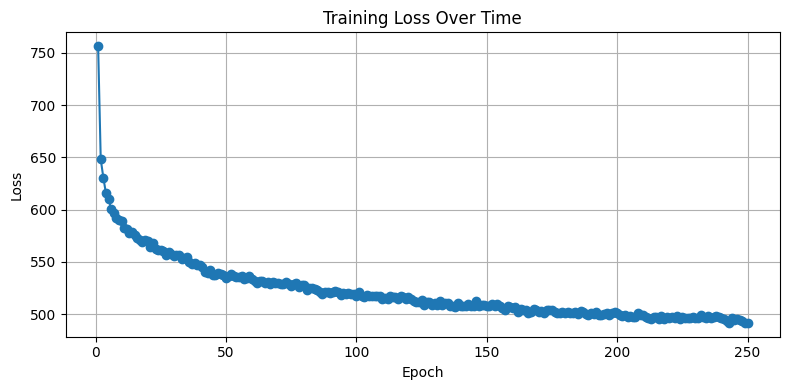

In [ ]:
# df_smote_1000
input_dim = df_smote_1000_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_1000_train.tensors[1]))
model_1000 = MLP(input_dim, output_dim)

# training
model_1000 = train_model(model_1000, df_smote_1000_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)


Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.14      0.21       200
           1       0.25      0.70      0.37       200
           2       0.46      0.42      0.44       200
           3       0.78      0.25      0.38       200
           4       1.00      0.98      0.99       200
           5       0.96      0.69      0.81       200
           6       1.00      0.99      1.00       200
           7       0.99      0.99      0.99       200
           8       1.00      0.98      0.99       200
           9       1.00      0.99      0.99       200
          10       0.80      0.99      0.89       200
          11       0.37      0.99      0.54       200
          12       1.00      0.01      0.01       200
          13       0.50      0.99      0.67       200
          14       0.61      0.96      0.75       200
          15       0.99      0.96      0.98       200
          16       0.62      0.41      0.49       200
   

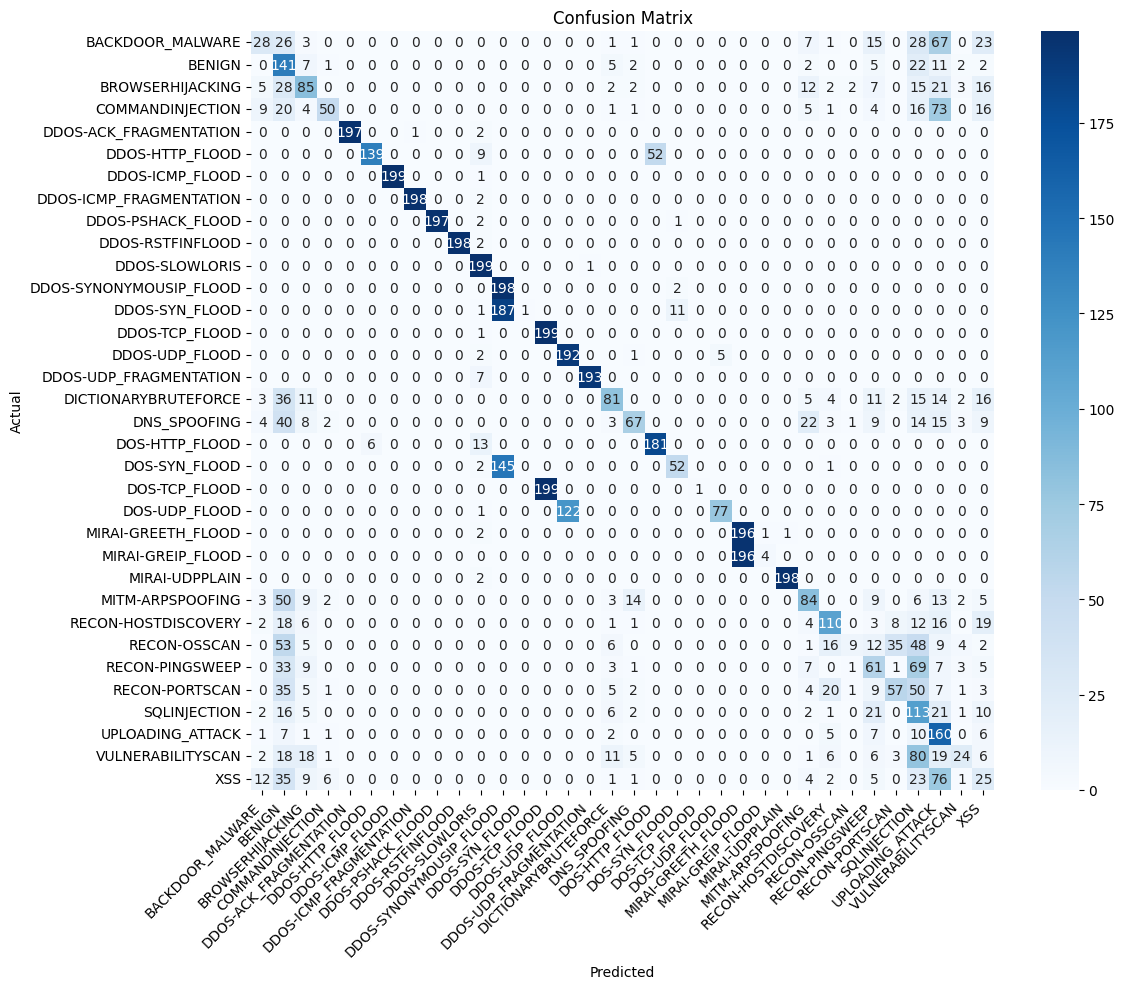

In [48]:
evaluate_model(model_1000, df_smote_1000_test_loader, df_smote_1000_le)

## Training and Evaluating SMOTE 2500 model

Epoch 10/250, Loss: 1410.1935
Epoch 20/250, Loss: 1366.2155
Epoch 30/250, Loss: 1346.5892
Epoch 40/250, Loss: 1329.7434
Epoch 50/250, Loss: 1307.5201
Epoch 60/250, Loss: 1296.5215
Epoch 70/250, Loss: 1295.8174
Epoch 80/250, Loss: 1287.5409
Epoch 90/250, Loss: 1272.2180
Epoch 100/250, Loss: 1268.8188
Epoch 110/250, Loss: 1265.5462
Epoch 120/250, Loss: 1262.2366
Epoch 130/250, Loss: 1248.8901
Epoch 140/250, Loss: 1252.5975
Epoch 150/250, Loss: 1248.4030
Epoch 160/250, Loss: 1245.6431
Epoch 170/250, Loss: 1240.5164
Epoch 180/250, Loss: 1238.3426
Epoch 190/250, Loss: 1234.1068
Epoch 200/250, Loss: 1232.5468
Epoch 210/250, Loss: 1229.2915
Epoch 220/250, Loss: 1230.4544
Epoch 230/250, Loss: 1227.7106
Epoch 240/250, Loss: 1225.5098
Epoch 250/250, Loss: 1221.7855


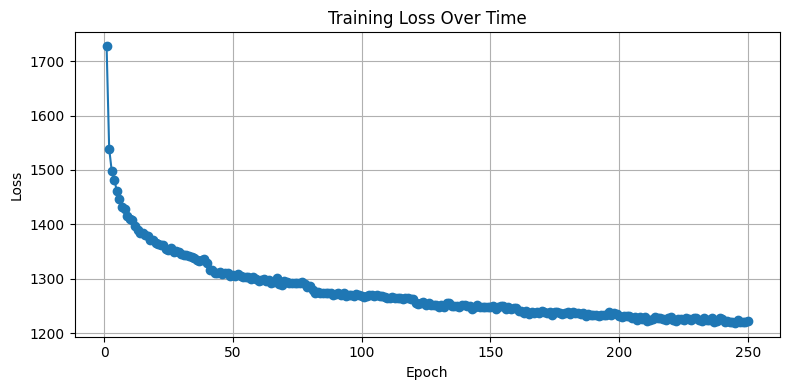

In [ ]:
input_dim = df_smote_2500_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_2500_train.tensors[1]))
model_2500 = MLP(input_dim, output_dim)

# training
model_2500 = train_model(model_2500, df_smote_2500_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)



Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.18      0.23       500
           1       0.33      0.55      0.41       500
           2       0.34      0.55      0.42       500
           3       0.76      0.28      0.41       500
           4       1.00      0.99      0.99       500
           5       0.92      0.76      0.83       500
           6       1.00      0.99      1.00       500
           7       1.00      0.99      0.99       500
           8       1.00      0.99      1.00       500
           9       1.00      1.00      1.00       500
          10       0.85      0.99      0.91       500
          11       0.38      0.99      0.55       500
          12       1.00      0.00      0.01       500
          13       0.54      0.68      0.61       500
          14       0.60      0.96      0.74       500
          15       1.00      0.99      0.99       500
          16       0.74      0.41      0.52       500
   

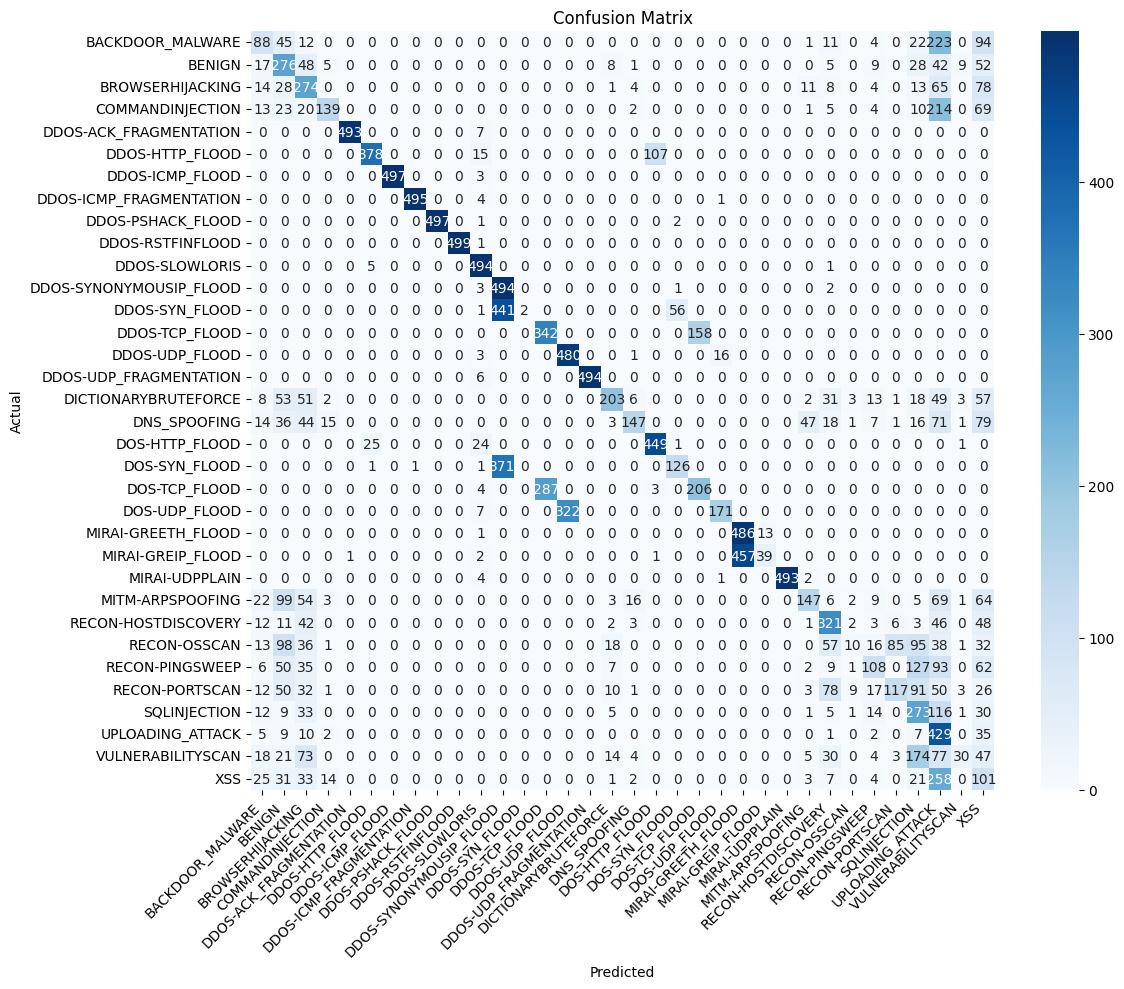

In [49]:
evaluate_model(model_2500, df_smote_2500_test_loader, df_smote_2500_le)

## Training and Evaluating SMOTE 5000 model

Epoch 10/250, Loss: 2738.7281
Epoch 20/250, Loss: 2671.5847
Epoch 30/250, Loss: 2644.4216
Epoch 40/250, Loss: 2612.7368
Epoch 50/250, Loss: 2565.3982
Epoch 60/250, Loss: 2549.3045
Epoch 70/250, Loss: 2541.5438
Epoch 80/250, Loss: 2534.6338
Epoch 90/250, Loss: 2502.3035
Epoch 100/250, Loss: 2499.8897
Epoch 110/250, Loss: 2494.7603
Epoch 120/250, Loss: 2484.9453
Epoch 130/250, Loss: 2467.1126
Epoch 140/250, Loss: 2464.8830
Epoch 150/250, Loss: 2458.1472
Epoch 160/250, Loss: 2453.8083
Epoch 170/250, Loss: 2436.4348
Epoch 180/250, Loss: 2434.4772
Epoch 190/250, Loss: 2430.8602
Epoch 200/250, Loss: 2428.7217
Epoch 210/250, Loss: 2417.3404
Epoch 220/250, Loss: 2415.3238
Epoch 230/250, Loss: 2415.5910
Epoch 240/250, Loss: 2413.8743
Epoch 250/250, Loss: 2403.2132


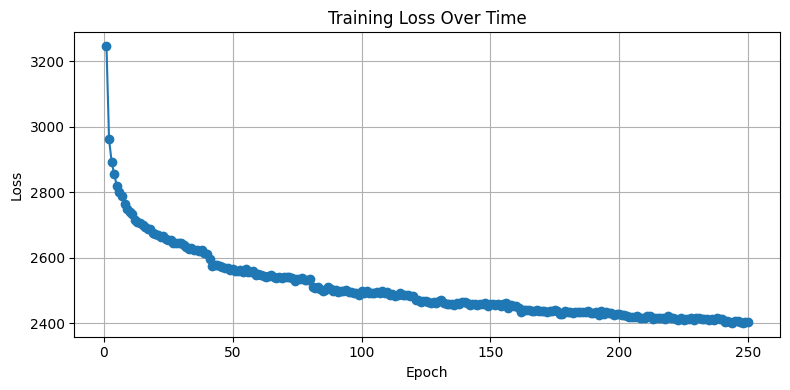

In [34]:
input_dim = df_smote_5000_train.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_5000_train.tensors[1]))
model_5000 = MLP(input_dim, output_dim)

# training
model_5000 = train_model(model_5000, df_smote_5000_train_loader, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)



Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.28      0.29      1000
           1       0.31      0.59      0.41      1000
           2       0.43      0.55      0.49      1000
           3       0.86      0.25      0.38      1000
           4       1.00      0.98      0.99      1000
           5       0.93      0.74      0.82      1000
           6       1.00      1.00      1.00      1000
           7       1.00      0.98      0.99      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000
          10       0.87      0.99      0.93      1000
          11       0.38      1.00      0.55      1000
          12       0.00      0.00      0.00      1000
          13       0.00      0.00      0.00      1000
          14       0.60      0.95      0.73      1000
          15       1.00      0.99      0.99      1000
          16       0.62      0.45      0.52      1000
   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

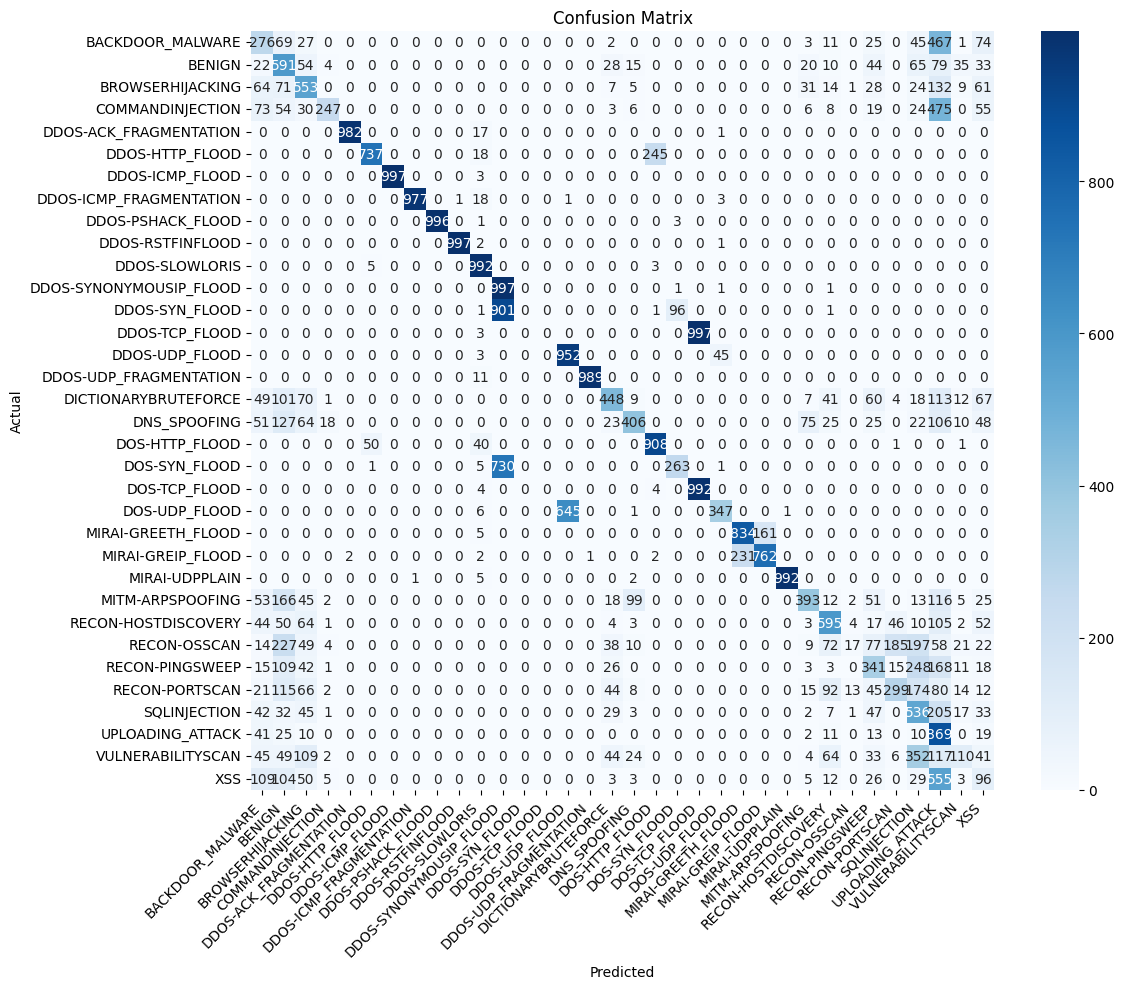

In [50]:
evaluate_model(model_5000, df_smote_5000_test_loader, df_smote_5000_le)

We got SMOTE_1000 accuracy to be 0.68.   
We got SMOTE_2500 accuracy to be 0.67.  

A little disappointed with these results and a little surprised that SMOTE_1000 did better than SMOTE_2500. Ill try using PCA to reduce the feature space.


## PCA

In [53]:
from sklearn.decomposition import PCA

def preprocess_with_pca(df, scale=True, n_components=None):
    le = LabelEncoder()
    df['Label_encoded'] = le.fit_transform(df['Label'])

    X = df.drop(columns=['Label', 'Label_encoded'])
    y = df['Label_encoded']

    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = X.values

    if n_components is None:
        raise ValueError("n_components must be specified when use_pca=True")
    pca = PCA(n_components=n_components)
    X = pca.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
    )

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    return train_ds, test_ds, train_loader, test_loader, le

In [54]:
df_smote_1000_train_pca_30, df_smote_1000_test_pca_30, df_smote_1000_train_loader_pca_30, df_smote_1000_test_loader_pca_30, df_smote_1000_pca_30_le = preprocess_with_pca(df_smote_1000, n_components=30)

## Training and Evaluating SMOTE 1000 model with PCA of 30 components

Epoch 10/250, Loss: 587.4280
Epoch 20/250, Loss: 568.4146
Epoch 30/250, Loss: 559.7994
Epoch 40/250, Loss: 550.2990
Epoch 50/250, Loss: 540.9989
Epoch 60/250, Loss: 536.7640
Epoch 70/250, Loss: 533.5074
Epoch 80/250, Loss: 531.0140
Epoch 90/250, Loss: 525.0146
Epoch 100/250, Loss: 522.0939
Epoch 110/250, Loss: 521.0713
Epoch 120/250, Loss: 517.2410
Epoch 130/250, Loss: 514.1827
Epoch 140/250, Loss: 514.6815
Epoch 150/250, Loss: 513.5455
Epoch 160/250, Loss: 511.6435
Epoch 170/250, Loss: 510.5915
Epoch 180/250, Loss: 505.2339
Epoch 190/250, Loss: 505.7525
Epoch 200/250, Loss: 504.8264
Epoch 210/250, Loss: 500.7768
Epoch 220/250, Loss: 503.0398
Epoch 230/250, Loss: 500.7540
Epoch 240/250, Loss: 503.6934
Epoch 250/250, Loss: 498.8963


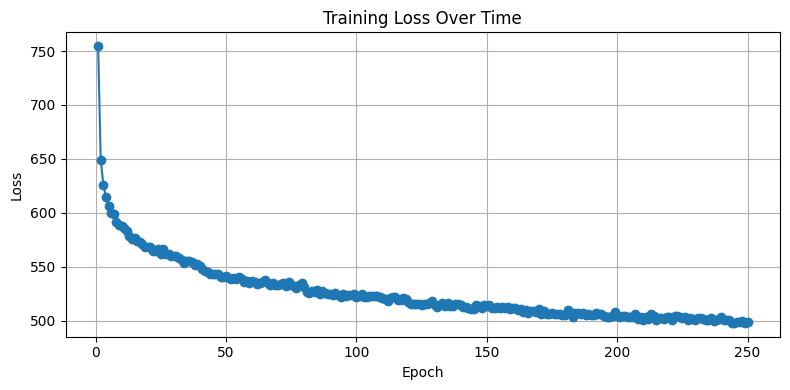

In [55]:
# df_smote_1000
input_dim = df_smote_1000_train_pca_30.tensors[0].shape[1]
output_dim = len(torch.unique(df_smote_1000_train_pca_30.tensors[1]))
model_1000_pca_30 = MLP(input_dim, output_dim)

# training
model_1000_pca_30 = train_model(model_1000_pca_30, df_smote_1000_train_loader_pca_30, num_epochs=250, lr=0.01, step_size=40, gamma=0.75)


Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.17      0.22       200
           1       0.28      0.66      0.39       200
           2       0.45      0.44      0.45       200
           3       0.78      0.23      0.36       200
           4       1.00      0.99      0.99       200
           5       0.97      0.69      0.80       200
           6       1.00      0.99      1.00       200
           7       1.00      0.99      0.99       200
           8       1.00      0.98      0.99       200
           9       1.00      0.99      0.99       200
          10       0.82      0.99      0.90       200
          11       0.38      0.90      0.54       200
          12       0.39      0.15      0.22       200
          13       0.00      0.00      0.00       200
          14       0.59      0.98      0.74       200
          15       1.00      0.96      0.98       200
          16       0.71      0.36      0.48       200
   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

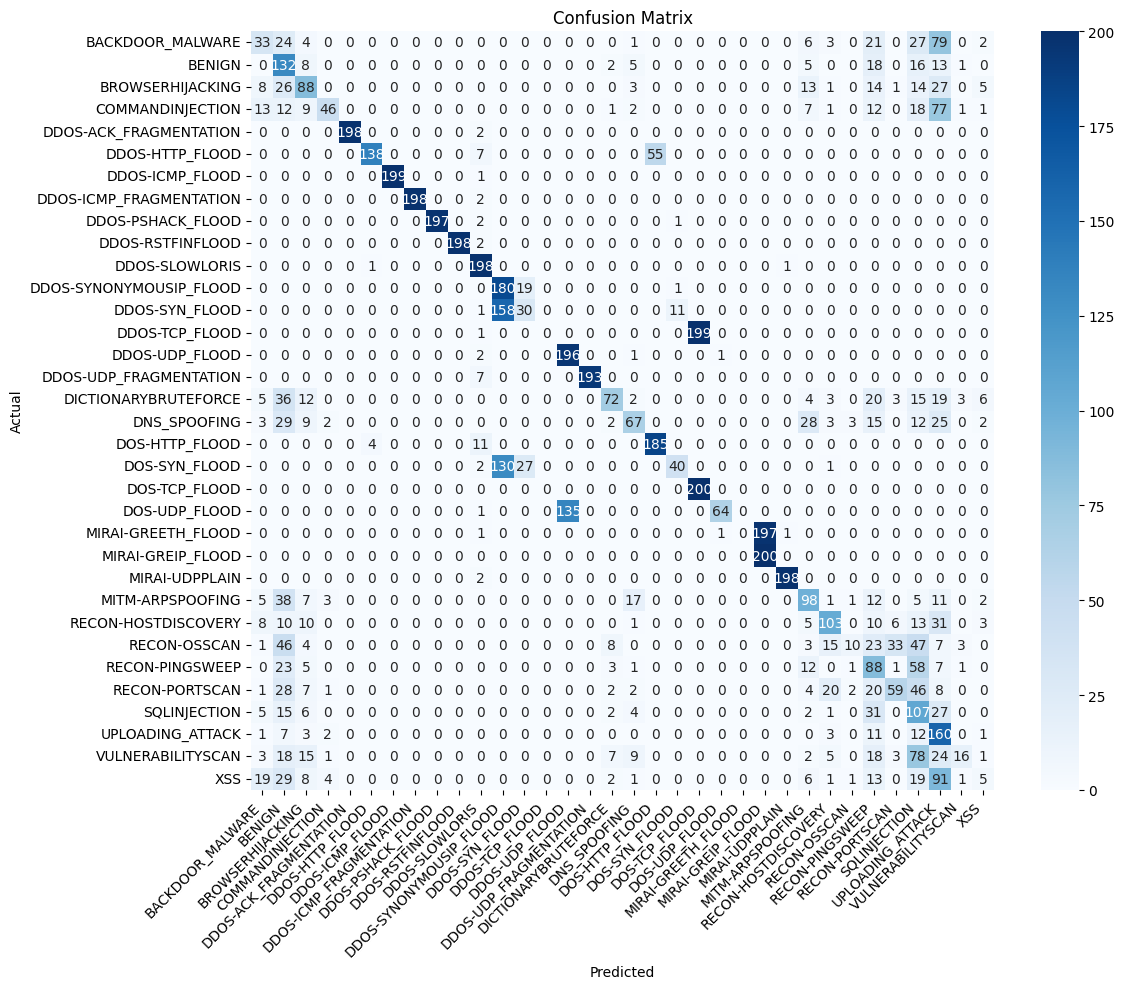

In [56]:
evaluate_model(model_1000_pca_30, df_smote_1000_test_loader_pca_30, df_smote_1000_pca_30_le)

Well, I guess this didnt matter too much either. Seems like XGBOOST might be the best for these classification tasks!.

# Saving the Model (so we dont have to retrain to do further testing)

In [39]:
torch.save(model_1000_pca_30.state_dict(), "model_1000_pca_30.pth")
torch.save(model_1000.state_dict(), "model_1000.pth")
torch.save(model_2500.state_dict(), "model_2500.pth")
torch.save(model_5000.state_dict(), "model_5000.pth")

In [ ]:
# how to reload the mdoels from the .pth files

# model = MLP(input_dim=?, output_dim=?)
# model.load_state_dict(torch.load("model_1000_pca_30.pth"))